# Section 1: Data Import and Preparation
This section imports the necessary libraries and reads data from the specified files. It processes the data to calculate the mid rates, which are the average of the bid and ask prices.

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from datetime import datetime

# Input file paths
ois_file_path = 'Dati/EURESTOIS=.xlsm'
forwards_ois_ecb_file_path = 'Dati/EUESTECBF=ICAP.xlsm'
deposit_file_path = 'Dati/EURDEPO=.xlsm'
fra3M_file_path = 'Dati/EUR3MFRA=.xlsm'
fra6M_file_path = 'Dati/6M/EUR6MFRA=.xlsm'
swap3M_file_path = 'Dati/EURAB3EIRS=.xlsm'
swap6M_file_path = 'Dati/6M/EURAB6EIRS=.xlsm'
futures3M_file_path = 'Dati/FUTURE3M.xlsm'

# ECB maintenance periods
ecb_maintenance_periods = {
    "JAN24": {"start": ql.Date(31, ql.January, 2024), "end": ql.Date(12, ql.March, 2024)},
    "MAR24": {"start": ql.Date(13, ql.March, 2024), "end": ql.Date(16, ql.April, 2024)},
    "APR24": {"start": ql.Date(17, ql.April, 2024), "end": ql.Date(11, ql.June, 2024)},
    "JUN24": {"start": ql.Date(12, ql.June, 2024), "end": ql.Date(23, ql.July, 2024)},
    "JUL24": {"start": ql.Date(24, ql.July, 2024), "end": ql.Date(17, ql.September, 2024)},
    "SEP24": {"start": ql.Date(18, ql.September, 2024), "end": ql.Date(22, ql.October, 2024)},
    "OCT24": {"start": ql.Date(23, ql.October, 2024), "end": ql.Date(17, ql.December, 2024)},
    "DEC24": {"start": ql.Date(18, ql.December, 2024), "end": "tbd"}
}

# Function to read data and calculate average rates
def load_and_process_data(file_path, sheet_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name, engine='openpyxl')
    data['Mid_Rate'] = (data['Bid'] + data['Ask']) / 2
    return data

# Load and process data
ois_data = load_and_process_data(ois_file_path, 'Sheet1')
forwards_ois_ecb_data = load_and_process_data(forwards_ois_ecb_file_path, 'Sheet1')
deposit_data = load_and_process_data(deposit_file_path, 'Sheet1')
fra_data3M = load_and_process_data(fra3M_file_path, 'Sheet1')
fra_data6M = load_and_process_data(fra6M_file_path, 'Sheet1')
swap_data3M = load_and_process_data(swap3M_file_path, 'Sheet1')
swap_data6M = load_and_process_data(swap6M_file_path, 'Sheet1')
futures_data3M = load_and_process_data(futures3M_file_path, 'Sheet1')


# Section 2: Convert Maturities and Set Evaluation Date
This section defines functions to convert maturity strings into QuantLib periods and processes the dataset to include these periods. It also sets up necessary adjustments for ECB maintenance periods and futures maturities, and defines specific maturities based on the Ametrano and Bianchetti study. The evaluation date for all calculations is set at the end.

In [15]:
# Map to convert calendar units to QuantLib periods
period_map = {
    "D": ql.Days,
    "W": ql.Weeks,
    "M": ql.Months,
    "Y": ql.Years
}

# Map for fixing days
fixing_days_map = {
    "ON": 0,
    "TN": 1,
    "SN": 2,
    "SW": 2,
    "2W": 2,
    "3W": 2
}

# Function to convert maturities to QuantLib periods, handling special cases
def convert_to_period(maturity):
    special_maturity_format = {
        "ON": ql.Period(1, ql.Days),
        "TN": ql.Period(2, ql.Days),
        "SN": ql.Period(3, ql.Days),
        "SW": ql.Period(1, ql.Weeks)
    }
    
    if maturity in special_maturity_format:
        return special_maturity_format[maturity]
    
    try:
        if 'X' in maturity:
            start, end = maturity.split('X')
            return ql.Period(int(start), ql.Months), ql.Period(int(end), ql.Months)
        num = int(maturity[:-1])
    except ValueError:
        raise ValueError(f"Invalid maturity format: {maturity}")
    
    unit = maturity[-1]
    return ql.Period(num, period_map[unit])

# Function to convert QuantLib dates to datetime for matplotlib
def _to_datetime(_date):
    return datetime(_date.year(), _date.month(), _date.dayOfMonth())

# Convert maturities to QuantLib periods
ois_data['Period'] = ois_data['Maturity'].apply(convert_to_period)
deposit_data['Period'] = deposit_data['Maturity'].apply(convert_to_period)
fra_data3M['Start_Period'], fra_data3M['End_Period'] = zip(*fra_data3M['Maturity'].apply(convert_to_period))
fra_data6M['Start_Period'], fra_data6M['End_Period'] = zip(*fra_data6M['Maturity'].apply(convert_to_period))
swap_data3M['Period'] = swap_data3M['Maturity'].apply(convert_to_period)
swap_data6M['Period'] = swap_data6M['Maturity'].apply(convert_to_period)

# Process forward OIS ECB data within maintenance periods
# Remove unused maintenance periods
del ecb_maintenance_periods["JAN24"]
del ecb_maintenance_periods["MAR24"]
del ecb_maintenance_periods["APR24"]
del ecb_maintenance_periods["JUN24"]
del ecb_maintenance_periods["DEC24"]

# Remove unused forward OIS ECB data
forwards_ois_ecb_data = forwards_ois_ecb_data[(forwards_ois_ecb_data.index > 0) & (forwards_ois_ecb_data.index < 4)]

# Set start and end dates for maintenance periods and forward OIS ECB maturities
period_keys = list(ecb_maintenance_periods.keys())
forwards_ois_ecb_data['Start_Period'] = [ecb_maintenance_periods[key]['start'] for key in period_keys[:len(forwards_ois_ecb_data)]]
forwards_ois_ecb_data['End_Period'] = [ecb_maintenance_periods[key]['end'] + 1 for key in period_keys[:len(forwards_ois_ecb_data)]]
forwards_ois_ecb_data.drop(columns=['Maturity'], inplace=True)

# Set IMM dates for Euribor futures maturities
def imm_date_corrected(data):
    month_str = data[:3]  # First three characters represent the month (e.g., 'JUL')
    year_str = data[3:]   # Remaining characters represent the year (e.g., '4')

    month = datetime.strptime(month_str, '%b').month
    year = 2020 + int(year_str)  # Corrected to handle years in 2020s
    
    # Calculate the next IMM date
    date = datetime(year, month, 1)
    return ql.IMM.nextDate(ql.Date(date.day, date.month, date.year))

futures_data3M['Start_Date'] = futures_data3M['Maturity'].apply(imm_date_corrected)
futures_data3M = futures_data3M[(futures_data3M.index > 4) & (futures_data3M.index < 11)]

# Define maturities based on Ametrano and Bianchetti study
ESTR_curve_deposit_maturities_chosen = ['ON', 'TN', 'SN'] 
fra3M_maturities_chosen = ['2X5','3X6', '4X7', '5X8', '6X9', '7X10', '8X11', '9X12','12X15','15X18', '16X19', '18X21','21X24']
fra_maturities_chosen = ['1X7', '2X8', '3X9', '4X10', '5X11', '6X12', '7X13', '8X14', '9X15', '10X16', '11X17', '12X18', '18X24']
swap_maturities_chosen = ['3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y', '40Y', '50Y']
futures_maturities_chosen = ['DEC4', 'MAR5', 'JUN5', 'SEP5', 'DEC5', 'MAR6']

# DEBUG: Print data
DEBUG_DATI = False
if DEBUG_DATI:
    print(f"Deposit Data: {deposit_data}")
    print(f"OIS Data: {ois_data}")
    print(f"Forwards OIS ECB Data: {forwards_ois_ecb_data}")
    print(f"FRA Data: {fra_data3M}")
    print(f"Swap Data: {swap_data3M}")
    print(f"Futures Data: {futures_data3M}")

# Set the evaluation date for the curves
settle_date = ql.Date(12, 7, 2024)
ql.Settings.instance().evaluationDate = settle_date




# Section 3: Building the €STR Discount Curve
This section defines a function to build the €STR discount curve. It initializes the curve with selected deposits, OIS pre-ECB, forward OIS ECB, and OIS post-ECB data. The function also includes an option to visualize the resulting yield curve.

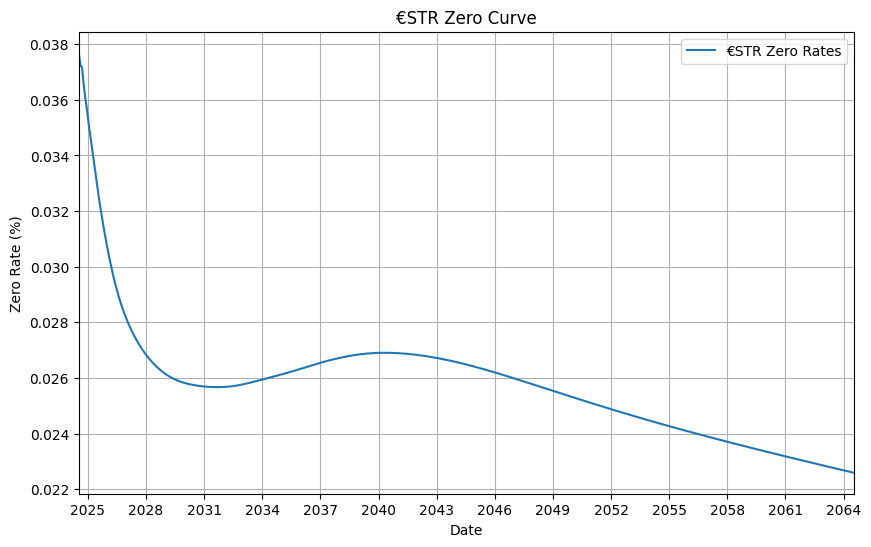

In [16]:
def estr_curve_builder(
    ois_data=ois_data,
    deposit_data=deposit_data,
    forwards_ois_ecb_data=forwards_ois_ecb_data,
    graph=True):
    
# Initialize an empty list to contain €STR curve helpers
    estr_helpers = []

    # Initialize the €STR curve
    estr = ql.Estr()

    # 1) Deposits
    # Add helpers for the first part of the curve from selected deposits
    selected_data = deposit_data[deposit_data['Maturity'].isin(ESTR_curve_deposit_maturities_chosen)]

    estr_helpers += [
        ql.DepositRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
            ql.Period(1, ql.Days),
            fixing_days_map[row['Maturity']],
            ql.TARGET(),
            ql.Following,
            False,
            ql.Actual360()
        )
        for _, row in selected_data.iterrows()
    ]

    # 2) OIS pre-ECB
    ois_pre_ecb = ois_data[ois_data.index < 1] # Watch for overlapping with forward OIS ECB
    # Add helpers for the second part of the curve from selected OIS pre-ECB
    estr_helpers += [
        ql.OISRateHelper(
            2, row['Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), estr
        )
        for index, row in ois_pre_ecb.iterrows()
    ]

    # 3) Forward OIS ECB dates
    # Add helpers for the third part of the curve from selected Forward OIS ECB
    estr_helpers += [
        ql.DatedOISRateHelper(
            row['Start_Period'], row['End_Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), estr
        )
        for index, row in forwards_ois_ecb_data.iterrows()
    ]

    # 4) OIS post-ECB
    ois_post_ecb = ois_data[ois_data.index > 7] # Watch for overlapping with forward OIS ECB
    estr_helpers += [
        ql.OISRateHelper(
            2, row['Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), estr
        )
        for index, row in ois_post_ecb.iterrows()
    ]

    # DEBUG: Print details of all helpers
    DEBUG_ESTR = False
    if DEBUG_ESTR:
        print("€STR Helpers:")
        for helper in estr_helpers:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

    # Build the €STR discount curve
    estr_curve = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), estr_helpers, ql.Actual365Fixed())
    estr_curve.enableExtrapolation() # Enable extrapolation for dates beyond the available data

    # Calculate discount factors for specified dates
    dates = [settle_date + ql.Period(i, ql.Months) for i in range(0, 40 * 12 + 1)]

    # Convert dates to datetime format
    dates_dt = [_to_datetime(date) for date in dates]
    estr_zero_rates = [
        estr_curve.zeroRate(date, ql.Actual365Fixed(), ql.Continuous).rate()
        for date in dates
    ]

    # Create the €STR yield curve graph
    if graph:
        plt.figure(figsize=(10, 6))
        plt.plot(dates_dt, estr_zero_rates, label='€STR Zero Rates')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlim(dates_dt[0], dates_dt[-1])
        plt.xlabel('Date')
        plt.ylabel('Zero Rate (%)')
        plt.title('€STR Zero Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    return estr_curve, estr_helpers, estr_zero_rates

estr_curve, estr_helpers, estr_zero_rates = estr_curve_builder()


# Section 4: ECB Liquidity Check for Jumps
In this section, we perform an ECB liquidity check for potential jumps due to ECB deadlines. By turning to flat forward rates instead of log-cubic discounts, we simplify the analysis and focus on the short-term forward rates over the first six months. The forward curve is plotted to identify any significant liquidity jumps.

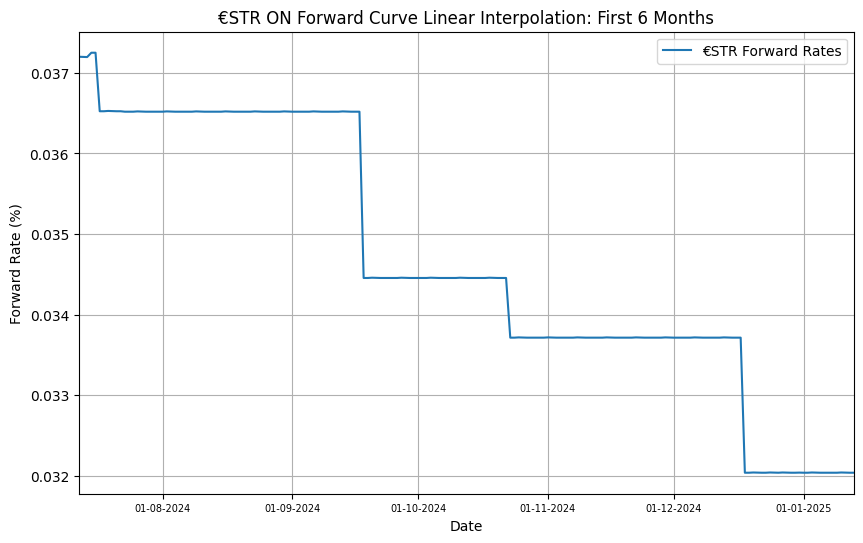

In [17]:
# To simplify analysis, we turn to flat forward rates instead of log-cubic discounts
estr_curve_ff = ql.PiecewiseFlatForward(
    0, ql.TARGET(), estr_helpers, ql.Actual365Fixed()
)
estr_curve_ff.enableExtrapolation()

# Restrict the plot to the first 6 months
end = ql.TARGET().advance(settle_date, ql.Period(6, ql.Months))

# Calculate the forward rates for the first 6 months
dates = [
    ql.Date(serial)
    for serial in range(settle_date.serialNumber(), end.serialNumber() + 1)
]

rates_ff = [
    estr_curve_ff.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Convert QuantLib dates to datetime
dates_dt = [d.to_date() for d in dates]

plt.figure(figsize=(10, 6))
plt.plot(dates_dt, rates_ff, label='€STR Forward Rates')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().tick_params(axis='x', labelsize=7)  # Set the x-axis label size to be smaller
plt.xlim(dates_dt[0], dates_dt[-1])
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('€STR ON Forward Curve Linear Interpolation: First 6 Months')
plt.legend()
plt.grid(True)
plt.show()

The graph shows a gradual stepwise decrease without abrupt changes. This smooth transition indicates the absence of liquidity jumps both on a monthly and annual basis. Overall, the curve suggests stability and no evident signs of liquidity issues over the observed period. The initial jump is due to the transition from deposit to OIS instruments.

# Section 5: Construction of the 3-Month Euribor Curve - No Synthetic Deposits
In this section, we construct the 3-month Euribor curve without using synthetic deposits. This involves defining the 3-month Euribor instance, adding deposit, futures, and swap rate helpers, and building both the spot and forward curves. The forward curve is then plotted to visualize the 3-month Euribor rates.

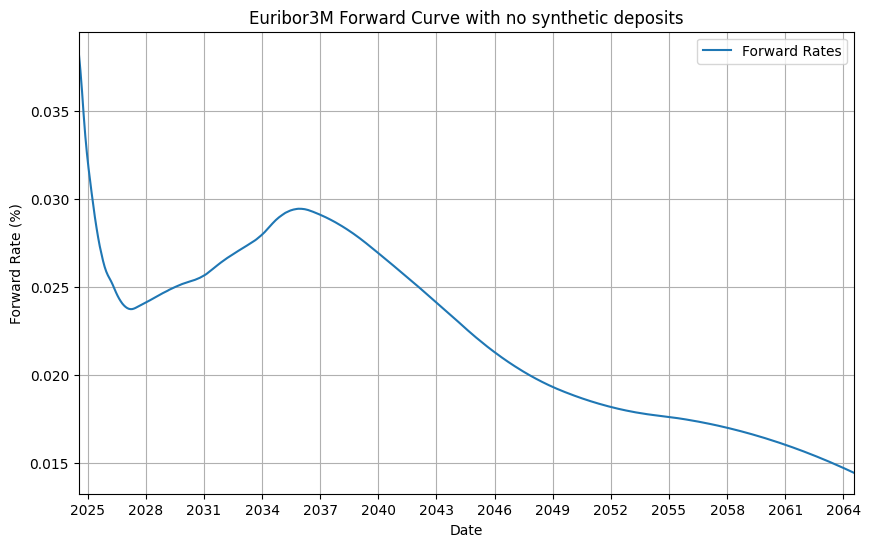

In [18]:
def euribor_curve_builder_no_synth_depo(
    estr_curve=estr_curve,
    deposit_data=deposit_data,
    futures_data3M=futures_data3M,
    swap_data3M=swap_data3M,
    futures_maturities_chosen=futures_maturities_chosen,
    swap_maturities_chosen=swap_maturities_chosen,
    dual_curve_approach=True,
    graph=True):

    # Define the 3-month Euribor instance
    Euribor3M = ql.Euribor3M()

    # 1) Deposits
    # First pillar of the EURIBOR curve: the 3-month deposit
    first_pillar_3m_deposit = deposit_data['Mid_Rate'][deposit_data['Maturity'] == '3M'].values[0]

    deposit_helper_3m = [
        ql.DepositRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(first_pillar_3m_deposit / 100)),
            ql.Period(3, ql.Months),
            3,  # 3 fixing days
            ql.TARGET(),
            ql.Following,
            False,
            ql.Actual360(),
        )
    ]

    # 2) Futures
    # Add futures for the second part of the curve from selected FRA
    future_helpers = []
    selected_data = futures_data3M[futures_data3M['Maturity'].isin(futures_maturities_chosen)]
    for index, row in selected_data.iterrows():
        future_helpers.append(
            ql.FuturesRateHelper(
                ql.QuoteHandle(ql.SimpleQuote((row['Mid_Rate']))),
                row['Start_Date'],
                Euribor3M,
                ql.QuoteHandle(),
            )
        )

    # Use €STR as the discount curve for the dual curve approach
    discount_curve = ql.YieldTermStructureHandle(estr_curve)

    
    # 3) Swaps
    # Add helpers for the third part of the curve from selected swaps
    swap_helpers = []
    selected_data = swap_data3M[swap_data3M['Maturity'].isin(swap_maturities_chosen)]

    if dual_curve_approach:
        for index, row in selected_data.iterrows():
            swap_helpers.append(ql.SwapRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
                ql.Thirty360(ql.Thirty360.BondBasis), Euribor3M, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve))
    else:
        for index, row in selected_data.iterrows():
            swap_helpers.append(ql.SwapRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
                ql.Thirty360(ql.Thirty360.BondBasis), Euribor3M, ql.QuoteHandle(), ql.Period(0, ql.Days)))
            
    # Debug: Print details of all EURIBOR helpers
    DEBUG_EUR = False
    if DEBUG_EUR:
        euribor_helpers = deposit_helper_3m + future_helpers + swap_helpers_dual
        print("Euribor Helpers:")
        for helper in euribor_helpers:
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

    # Build the spot curve
    Euribor3M_curve_no_synth_depo = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), deposit_helper_3m + future_helpers + swap_helpers, ql.Actual365Fixed()
    )
    Euribor3M_curve_no_synth_depo.enableExtrapolation()

    # Build the forward curve
    spot_date = Euribor3M_curve_no_synth_depo.referenceDate()  # Set the evaluation date as the spot date
    dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 40 * 12 + 1)]
    dates_dt = [_to_datetime(date) for date in dates]

    euribor3m_f_curve_no_synth_depo = [
        Euribor3M_curve_no_synth_depo.forwardRate(
            d, Euribor3M.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the forward EURIBOR curve
    if graph:
        plt.figure(figsize=(10, 6))
        plt.plot(dates_dt, euribor3m_f_curve_no_synth_depo, label='Forward Rates')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlim([dates_dt[0], dates_dt[-1]])
        plt.xlabel('Date')
        plt.ylabel('Forward Rate (%)')
        plt.title('Euribor3M Forward Curve with no synthetic deposits')
        plt.legend()
        plt.grid(True)
        plt.show()

    return Euribor3M_curve_no_synth_depo, euribor3m_f_curve_no_synth_depo, deposit_helper_3m, future_helpers, swap_helpers, spot_date, Euribor3M

# Build the Euribor curve with no synthetic deposits
Euribor3M_curve_no_synth_depo, euribor3m_f_curve_no_synth_depo, deposit_helper_3m, future_helpers, swap_helpers_dual, spot_date, Euribor3M = euribor_curve_builder_no_synth_depo()


# Section 6: Calculation of Basis and Creation of Synthetic Deposits
In this section, we calculate the basis (spread) between the forward 3-month EURIBOR and €STR rates. We then create synthetic deposit helpers for various short-term maturities by adjusting the €STR forward rates with the calculated spread. This process enables the construction of a more accurate 3-month EURIBOR curve.


In [19]:
def synthetic_deposit_builder(
    Euribor3M_curve_no_synth_depo=Euribor3M_curve_no_synth_depo,
    estr_curve=estr_curve,
    spot_date=spot_date,
    print_alpha=True):
    
    # Set the spot date to one day after the settlement date (fixing convention)
    d = ql.TARGET().advance(spot_date, 1, ql.Days)

    # Bootstrap the forward 3-month rate from the existing 3-month EURIBOR curve
    Euribor3M_tomorrowX3M_f_rate = Euribor3M_curve_no_synth_depo.forwardRate(
        d, ql.TARGET().advance(d, 3, ql.Months), ql.Actual360(), ql.Simple).rate()

    # Bootstrap the forward 3-month rate from the €STR curve
    estr_tomorrowX3M_f_rate = estr_curve.forwardRate(
        d, ql.TARGET().advance(d, 3, ql.Months), ql.Actual360(), ql.Simple).rate()

    # Calculate the spread (alpha) between the 3-month forward EURIBOR rate and the 3-month forward €STR rate
    alpha = Euribor3M_tomorrowX3M_f_rate - estr_tomorrowX3M_f_rate

    if print_alpha:
        print(f"Alpha: {alpha}")     

    # Construct helpers for synthetic deposits
    synth_deposit_helper_ON_to_2M = []

    # Define a list of tuples representing the maturities for which synthetic deposits will be created
    # Each tuple contains a number (n) and a unit of time (Days, Weeks, Months)
    for n, units in [
        (1, ql.Days),
        (1, ql.Weeks),
        (2, ql.Weeks),
        (3, ql.Weeks),
        (1, ql.Months),
        (2, ql.Months),
    ]:
        # Calculate the forward rate from the €STR curve for the given duration and adjust the Euribor forward rate by adding the previously calculated spread (alpha)
        estr_xX3M_f_rate = estr_curve.forwardRate(
            spot_date, ql.TARGET().advance(spot_date, n, units), ql.Actual360(), ql.Simple
        ).rate()
        
        synth_EURIBOR3M_xX3M_f_rate = estr_xX3M_f_rate + alpha

        # Create a synthetic deposit helper with the calculated forward rate and add it to the list
        synth_deposit_helper_ON_to_2M.append(
            ql.DepositRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(synth_EURIBOR3M_xX3M_f_rate)),  # Adjusted forward rate
                ql.Period(n, units),  # Duration for the synthetic deposit
                2,  # Settlement days
                ql.TARGET(),  # Calendar
                ql.Following,  # Business day convention
                False,  # End of month flag
                ql.Actual360(),  # Day count convention
            )
        )

    # DEBUG: Print details of each synthetic deposit helper
    DEBUG_SYNTH = False
    if DEBUG_SYNTH:
        print("Synthetic Deposit Helpers:")
        for helper in synth_deposit_helper_ON_to_2M:
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")
            
    return synth_deposit_helper_ON_to_2M

# Build synthetic deposit helpers
synth_deposit_helper_ON_to_2M = synthetic_deposit_builder()


Alpha: 0.002246065826072466


# Section 7: Construction of the Euribor3M forward Curve with Synthetic Deposits
In this section, we construct the forward Euribor curve using synthetic deposits. We create a combined list of helpers, including synthetic deposits, deposits, futures, and swaps. This combined list is used to build the Euribor curve, which is then plotted to visualize the forward rates.

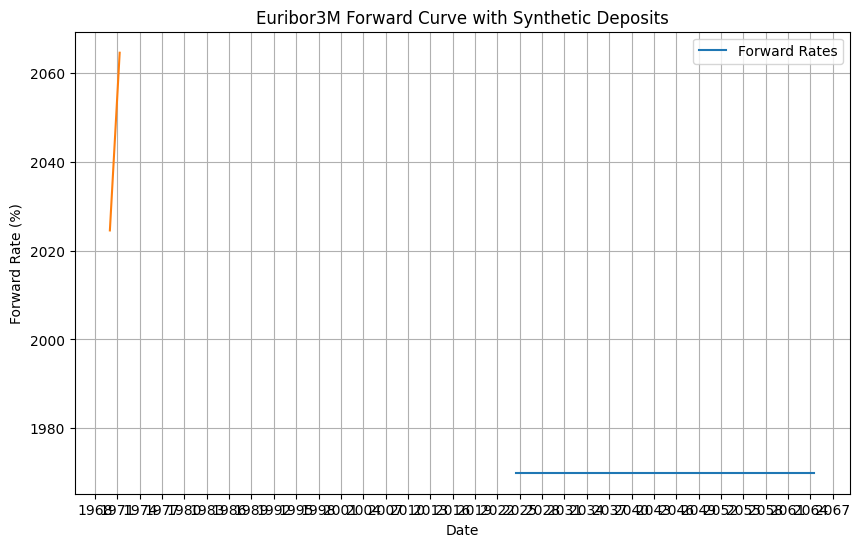

In [20]:
def euribor_curve_builder_with_synth_depo(
    synth_deposit_helper_ON_to_2M=synth_deposit_helper_ON_to_2M, 
    deposit_helper_3m=deposit_helper_3m,
    future_helpers=future_helpers, 
    swap_helpers_dual=swap_helpers_dual, 
    graph=True):
    
    # Construct the corrected EURIBOR curve using synthetic deposit helpers
    Euribor3M_curve_with_synth_depo = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), synth_deposit_helper_ON_to_2M + deposit_helper_3m + future_helpers + swap_helpers_dual, ql.Actual365Fixed()
    )
    Euribor3M_curve_with_synth_depo.enableExtrapolation()

    # DEBUG: Print details of the corrected EURIBOR curve helpers
    DEBUG_EU_CORR = False
    if DEBUG_EU_CORR:
        print("Corrected Euribor Helpers:")
        for helper in synth_deposit_helper_ON_to_2M + deposit_helper_3m + future_helpers + swap_helpers_dual:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Helper Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

    dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 40 * 12 + 1)]
    dates_dt = [_to_datetime(date) for date in dates]

    # Construct the corrected forward EURIBOR curve
    euribor3m_f_curve = [
        Euribor3M_curve_with_synth_depo.forwardRate(
            d, Euribor3M.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the corrected forward EURIBOR curve
    if graph:
        plt.figure(figsize=(10, 6))
        plt.plot(dates_dt, euribor3m_f_curve, label='Forward Rates')
        plt.plot(dates_dt)
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlabel('Date')
        plt.ylabel('Forward Rate (%)')
        plt.title('Euribor3M Forward Curve with Synthetic Deposits')
        plt.legend()
        plt.grid(True)
        plt.show()

    return Euribor3M_curve_with_synth_depo, euribor3m_f_curve

Euribor3M_curve_with_synth_depo, euribor3m_f_curve = euribor_curve_builder_with_synth_depo()


# Section 8: Construction of the Euribor3M forward Curve using the Single Curve Approach 
In this section, we construct the forward Euribor curve using a single curve approach. We add the necessary swap helpers and combine them with synthetic deposit helpers, deposit helpers, and futures helpers. The resulting single curve forward Euribor curve is then plotted to visualize the forward rates.


In [21]:

# Build the Euribor curve with no synthetic deposits
_,_,_,_, swap_helpers_single,*_ =   euribor_curve_builder_no_synth_depo(
                                    dual_curve_approach=False,
                                    graph=False)



# Construct the single curve Euribor using the helpers for synthetic deposits, deposits, futures, and single curve swaps
Euribor3M_curve_single = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), synth_deposit_helper_ON_to_2M + deposit_helper_3m + future_helpers + swap_helpers_single, ql.Actual365Fixed()
)
Euribor3M_curve_single.enableExtrapolation()

# Construct the single curve forward Euribor curve
dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 40 * 12 + 1)]
dates_dt = [_to_datetime(date) for date in dates]

euribor3m_f_curve_single = [
    Euribor3M_curve_single.forwardRate(
        d, Euribor3M.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]



# Section 9: Comparison of Dual Curve and Single Euribor3M Forward Curves
In this section, we calculate the basis point differences between the dual curve and single curve zero and forward Euribor curves. We plot these differences to visualize the comparison between the two approaches.


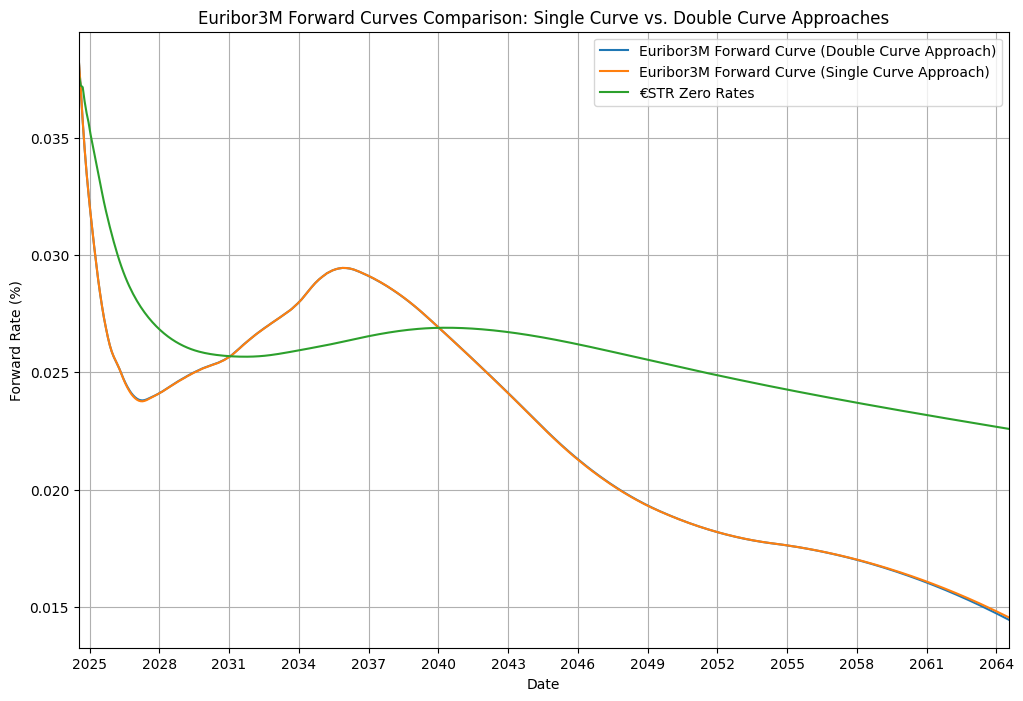

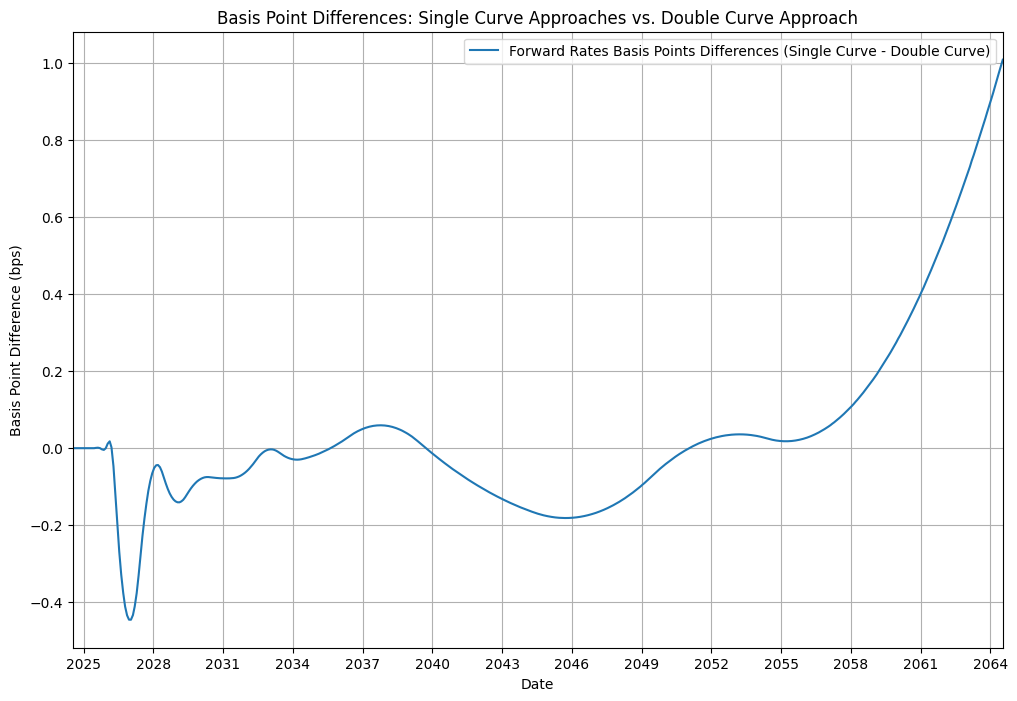

In [22]:

# Calculate the differences in basis points between the dual curve and single curve forward Euribor curves
basis_point_differences = [
    (d, (fr_single - fr_dual) * 10000)
    for d, fr_single, fr_dual in zip(dates, euribor3m_f_curve_single, euribor3m_f_curve)
]

# Extract the dates and basis point differences for plotting
basis_dates, bp_diffs = zip(*basis_point_differences)

# Plot the forward Euribor3M curves for comparison between single curve and double curve approaches
plt.figure(figsize=(12, 8))
plt.plot(dates_dt, euribor3m_f_curve, label='Euribor3M Forward Curve (Double Curve Approach)')
plt.plot(dates_dt, euribor3m_f_curve_single, label='Euribor3M Forward Curve (Single Curve Approach)')
plt.plot(dates_dt, estr_zero_rates, label='€STR Zero Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([dates_dt[0], dates_dt[-1]])
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('Euribor3M Forward Curves Comparison: Single Curve vs. Double Curve Approaches')
plt.legend()
plt.grid(True)
plt.show()

# Plot the basis point differences between the single curve and double curve approaches
plt.figure(figsize=(12, 8))
plt.plot(dates_dt, bp_diffs, label='Forward Rates Basis Points Differences (Single Curve - Double Curve)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(dates_dt[0], dates_dt[-1])
plt.xlabel('Date')
plt.ylabel('Basis Point Difference (bps)')
plt.title('Basis Point Differences: Single Curve Approaches vs. Double Curve Approach')
plt.legend()
plt.grid(True)
plt.show()


#=========================================Euribor6M Curve=======================================================



# Section 10: Construction of the Euribor6M Forward Curve and comparison with the Euribor3M Forward Curve
In this section, we construct the forward Euribor6M curve using the dual curve approach. We then compare the Euribor6M forward curve with the Euribor3M forward curve to identify any differences between the two curves.

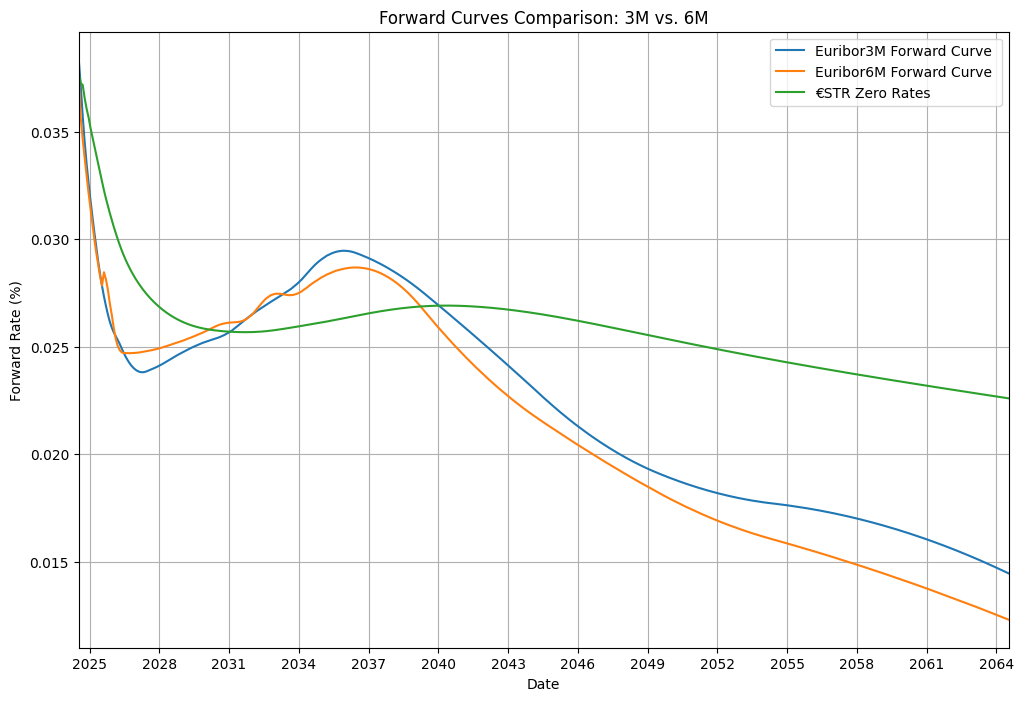

In [23]:
euribor6m = ql.Euribor6M()
# 1) Depositi
# Primo pillar della curva EURIBOR: il deposito a 6 mesi
first_pillar_6m_deposit = deposit_data['Mid_Rate'][deposit_data['Maturity'] == '6M'].values[0]

deposit_helper_6m = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(first_pillar_6m_deposit / 100)),
        ql.Period(6, ql.Months),
        3,  # 3 giorni di fixing
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
]

# 2) FRA
# Aggiungo gli helpers per la seconda parte della curva dai FRA (2 anni)
fra_helpers_6m = []
for index, row in fra_data6M.iterrows():
    fra_helpers_6m.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
                                     row['Start_Period'], euribor6m))

discount_curve = ql.YieldTermStructureHandle(estr_curve)

# 3) SWAP
# Aggiungo gli helpers per la terza parte della curva dai SWAP
swap_helpers_6m = []
selected_data = swap_data6M[swap_data6M['Maturity'].isin(swap_maturities_chosen)]
for index, row in selected_data.iterrows():
    swap_helpers_6m.append(ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis), euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve))

# Build the spot curve
euribor6m_curve_no_synth_depo = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), deposit_helper_6m + fra_helpers_6m + swap_helpers_6m, ql.Actual365Fixed()
)
euribor6m_curve_no_synth_depo.enableExtrapolation()

#======================build and add synthetic deposits====================

# Set the spot date to one day after the settlement date (fixing convention)
d = ql.TARGET().advance(spot_date, 1, ql.Days)

# Bootsrap del tasso forward a 6 mesi dalla curva EURIBOR a 6 mesi preesistente
euribor6m_forward_curve_no_synth_depo = euribor6m_curve_no_synth_depo.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple).rate()

# Bootstrap the forward 6-month rate from the existing 6-month EURIBOR curve
euribor6m_tomorrowX6M_f_rate = euribor6m_curve_no_synth_depo.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple).rate()

# Bootstrap the forward 6-month rate from the €STR curve
estr_tomorrowX6M_f_rate = estr_curve.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple).rate()

# Calculate the spread (alpha) between the 6-month forward EURIBOR rate and the 3-month forward €STR rate
alpha = euribor6m_tomorrowX6M_f_rate - estr_tomorrowX6M_f_rate

# Construct helpers for synthetic deposits
synth_deposit_helper_ON_to_5M = []

for n, units in [
    (1, ql.Days),
    (1, ql.Weeks),
    (2, ql.Weeks),
    (3, ql.Weeks),
    (1, ql.Months),
    (2, ql.Months),
    (3, ql.Months),
    (4, ql.Months),
    (5, ql.Months),
]:
        # Calculate the forward rate from the €STR curve for the given duration and adjust the Euribor forward rate by adding the previously calculated spread (alpha)
    estr_xX6M_f_rate = estr_curve.forwardRate(
        spot_date, ql.TARGET().advance(spot_date, n, units), ql.Actual360(), ql.Simple
    ).rate()
    
    synth_EURIBOR3M_xX6M_f_rate = estr_xX6M_f_rate + alpha

    # Create a synthetic deposit helper with the calculated forward rate and add it to the list
    synth_deposit_helper_ON_to_5M.append(
        ql.DepositRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(synth_EURIBOR3M_xX6M_f_rate)),  # Adjusted forward rate
            ql.Period(n, units),  # Duration for the synthetic deposit
            2,  # Settlement days
            ql.TARGET(),  # Calendar
            ql.Following,  # Business day convention
            False,  # End of month flag
            ql.Actual360(),  # Day count convention
        )
    )

euribor6m_curve = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), synth_deposit_helper_ON_to_5M + deposit_helper_6m + fra_helpers_6m + swap_helpers_6m, ql.Actual365Fixed()
)
euribor6m_curve.enableExtrapolation()

# Build the forward curve
euribor6m_f_curve = [
    euribor6m_curve.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Plot the comparison graph of the forward curves + €STR zero rates
plt.figure(figsize=(12, 8))
plt.plot(dates_dt, euribor3m_f_curve, label='Euribor3M Forward Curve ')
plt.plot(dates_dt, euribor6m_f_curve, label='Euribor6M Forward Curve ')
plt.plot(dates_dt, estr_zero_rates, label='€STR Zero Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([dates_dt[0], dates_dt[-1]])
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('Forward Curves Comparison: 3M vs. 6M')
plt.legend()
plt.grid(True)
plt.show()

# Section 11: Building and Comparing Different Euribor3M Forward Curve with Different Instrument Bootstrapping Sets
In this section, we build and compare different Euribor forward curves using different instrument bootstrapping sets. We define the instrument sets for each curve and build the forward curves using the dual curve approach. We then plot the forward curves to compare the results.

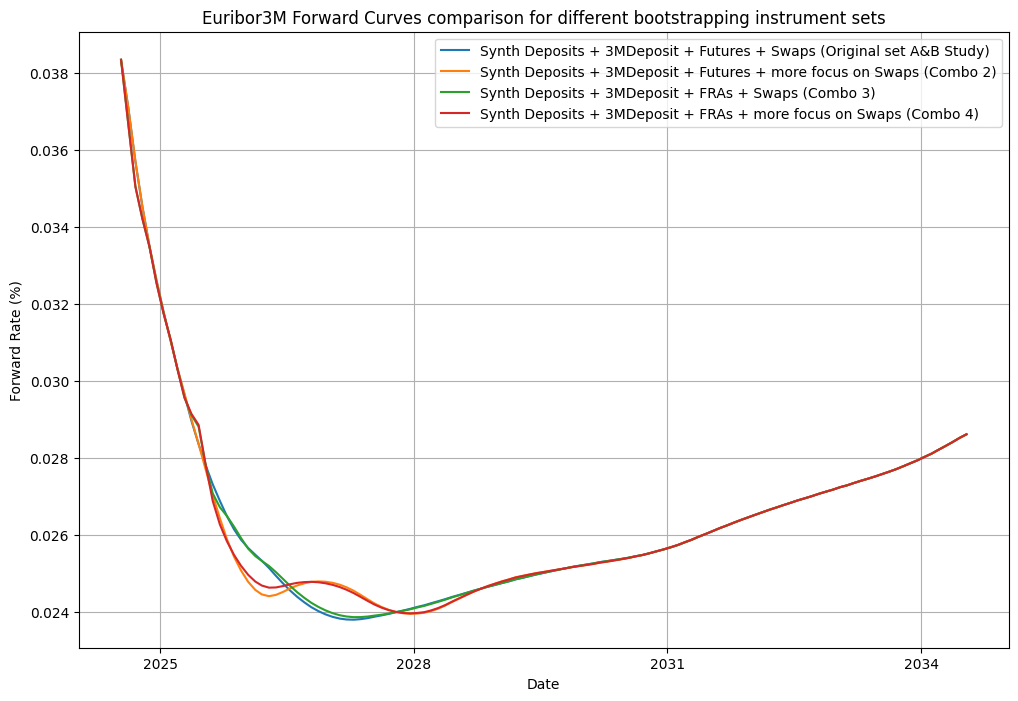

In [24]:
def different_i_b_sets_curves_builder(
    synth_deposit_helper_ON_to_2M=synth_deposit_helper_ON_to_2M, 
    deposit_helper_3m=deposit_helper_3m,
    swap_helpers_dual=swap_helpers_dual, 
    estr_curve=estr_curve,
    Euribor3M_curve_with_synth_depo=Euribor3M_curve_with_synth_depo,
    futures_data3M=futures_data3M,
    swap_data3M=swap_data3M, 
    fra_data3M=fra_data3M, 
    graph=False, 
    graph_comparison=True):

    #========================Combination 2: Greater focus on swaps ===========================================
    futures_maturities_chosen_combo2 = ['DEC4', 'MAR5', 'JUN5'] # We cannot reduce the maturities of the futures further or the algorithm will not converge
    focus_swap_maturities_chosen = ['18','2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y', '40Y', '50Y']

    # DEPOSITS and SYNTHETIC DEPOSITS are the same as in combination 1

    # FUTURES
    selected_data = futures_data3M[futures_data3M['Maturity'].isin(futures_maturities_chosen_combo2)]
    futures_helpers_combo2 = []
    for index, row in selected_data.iterrows():
        futures_helpers_combo2.append(
            ql.FuturesRateHelper(
                ql.QuoteHandle(ql.SimpleQuote((row['Mid_Rate']))),
                row['Start_Date'],
                Euribor3M,
                ql.QuoteHandle(),
            )
        )

    # SWAPS
    discount_curve = ql.YieldTermStructureHandle(estr_curve)
    focus_swap_helpers = []
    selected_data = swap_data3M[swap_data3M['Maturity'].isin(focus_swap_maturities_chosen)]
    for index, row in selected_data.iterrows():
        focus_swap_helpers.append(ql.SwapRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), 
            row['Period'], 
            ql.TARGET(), 
            ql.Annual, 
            ql.Unadjusted,
            ql.Thirty360(ql.Thirty360.BondBasis), 
            Euribor3M, 
            ql.QuoteHandle(), 
            ql.Period(0, ql.Days), 
            discount_curve))
        
    # DEBUG: Print details of EURIBOR combo 2 helpers
    DEBUG_EU_COMBO2 = False
    if DEBUG_EU_COMBO2:
        print("Euribor combo 2 helpers:")
        for helper in synth_deposit_helper_ON_to_2M + deposit_helper_3m + futures_helpers_combo2 + focus_swap_helpers:
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

    # Build the curve
    all_helpers_combo2 = synth_deposit_helper_ON_to_2M + deposit_helper_3m + futures_helpers_combo2 + focus_swap_helpers 

    Euribor3M_curve_combo2 = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), all_helpers_combo2, ql.Actual365Fixed()
    )
    Euribor3M_curve_combo2.enableExtrapolation()

    # Build the forward curve
    dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 40 * 12 + 1)]
    dates_dt = [_to_datetime(date) for date in dates]

    euribor3m_f_curve_combo2 = [
        Euribor3M_curve_combo2.forwardRate(
            d, Euribor3M.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the forward curve
    if graph:
        plt.figure(figsize=(10, 6))
        plt.plot(dates_dt, euribor3m_f_curve_combo2, label='Forward Rates')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlabel('Date')
        plt.ylabel('Forward Rate (%)')
        plt.title('3M Euribor Forward Curve: Synth Deposits + 3MDeposit + Futures + more focus on Swaps (Combo 2)')
        plt.legend()
        plt.grid(True)
        plt.show()

    #=================================Combination 3: Deposits and FRA and swaps===================================

    # DEPOSITS, SYNTHETIC DEPOSITS, and SWAPS are the same as in combination 1

    # FRA
    fra_helpers_combo3 = []
    for index, row in fra_data3M.iterrows():
        fra_helpers_combo3.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
                                        row['Start_Period'], Euribor3M))

    DEBUG_EU_COMBO3 = False
    if DEBUG_EU_COMBO3:
        print("Euribor combo 3 helpers:")
        for helper in synth_deposit_helper_ON_to_2M + deposit_helper_3m + fra_helpers_combo3+ swap_helpers_dual:
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

    # Build the curve
    all_helpers_combo3 = synth_deposit_helper_ON_to_2M + deposit_helper_3m + fra_helpers_combo3 + swap_helpers_dual

    Euribor3M_curve_combo3 = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), all_helpers_combo3, ql.Actual365Fixed()
    )

    Euribor3M_curve_combo3.enableExtrapolation()

    # Build the forward curve
    euribor3m_f_curve_combo3 = [
        Euribor3M_curve_combo3.forwardRate(
            d, Euribor3M.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the forward curve
    if graph:
        plt.figure(figsize=(10, 6))
        plt.plot(dates_dt, euribor3m_f_curve_combo3, label='Forward Rates')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlabel('Date')
        plt.ylabel('Forward Rate (%)')
        plt.title('Euribor3M Forward curve: Synth Deposits + 3MDeposit + FRAs + Swaps (Combo 3)')
        plt.legend()
        plt.grid(True)
        plt.show()

    #====================Combination 4: Deposits and FRA with focus on swaps===============================

    fra3M_maturities_chosen_combo4 = ['2X5','3X6','4X7','5X8','6X9','7X10','8X11','9X12','10X13','12X15']

    # DEPOSITS and SYNTHETIC DEPOSITS are the same as in combination 1 and SWAPS are the same as in combination 2

    # FRA
    fra_helpers_combo4 = []
    selected_data = fra_data3M[fra_data3M['Maturity'].isin(fra3M_maturities_chosen_combo4)]
    for index, row in selected_data.iterrows():
        fra_helpers_combo4.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
                                        row['Start_Period'], Euribor3M))

    DEBUG_EU_COMBO4 = False
    if DEBUG_EU_COMBO4:
        print("Euribor combo 4 helpers:")
        for helper in synth_deposit_helper_ON_to_2M + deposit_helper_3m + fra_helpers_combo4+ focus_swap_helpers:
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

    # Build the EURIBOR curve
    all_helpers_combo4 = synth_deposit_helper_ON_to_2M + deposit_helper_3m + fra_helpers_combo4 + focus_swap_helpers

    Euribor3M_curve_combo4 = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), all_helpers_combo4, ql.Actual365Fixed()
    )

    Euribor3M_curve_combo4.enableExtrapolation()

    # Build the EURIBOR forward curve

    euribor3m_f_curve_combo4 = [
        Euribor3M_curve_combo4.forwardRate(
            d, Euribor3M.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the forward curve
    if graph:
        plt.figure(figsize=(10, 6))
        plt.plot(dates_dt, euribor3m_f_curve_combo4, label='Forward Rates')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlabel('Date')
        plt.ylabel('Forward Rate (%)')
        plt.title('Euribor3M Forward Curve: Synth Deposits + 3MDeposit + FRAs + more focus on Swaps (Combo 4)')
        plt.legend()
        plt.grid(True)
        plt.show()

    #==================COMBINED COMPARISON PLOT OF ALL 4 COMBINATIONS=============================

    # Combined plot

    dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 10 * 12 + 1)]
    dates_dt = [_to_datetime(date) for date in dates]

    euribor3m_f_curve = [
        Euribor3M_curve_with_synth_depo.forwardRate(
            d, Euribor3M.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    euribor3m_f_curve_combo2 = [
        Euribor3M_curve_combo2.forwardRate(
            d, Euribor3M.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    euribor3m_f_curve_combo3 = [
        Euribor3M_curve_combo3.forwardRate(
            d, Euribor3M.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    euribor3m_f_curve_combo4 = [
        Euribor3M_curve_combo4.forwardRate(
            d, Euribor3M.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the combined comparison of all 4 combinations
    if graph_comparison:
        plt.figure(figsize=(12, 8))
        plt.plot(dates_dt, euribor3m_f_curve, label='Synth Deposits + 3MDeposit + Futures + Swaps (Original set A&B Study)')
        plt.plot(dates_dt, euribor3m_f_curve_combo2, label='Synth Deposits + 3MDeposit + Futures + more focus on Swaps (Combo 2)')
        plt.plot(dates_dt, euribor3m_f_curve_combo3, label='Synth Deposits + 3MDeposit + FRAs + Swaps (Combo 3)')
        plt.plot(dates_dt, euribor3m_f_curve_combo4, label='Synth Deposits + 3MDeposit + FRAs + more focus on Swaps (Combo 4)')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlabel('Date')
        plt.ylabel('Forward Rate (%)')
        plt.title('Euribor3M Forward Curves comparison for different bootstrapping instrument sets')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return euribor3m_f_curve, euribor3m_f_curve_combo2, euribor3m_f_curve_combo3, euribor3m_f_curve_combo4, dates

euribor3m_f_curve, euribor3m_f_curve_combo2, euribor3m_f_curve_combo3, euribor3m_f_curve_combo4, dates = different_i_b_sets_curves_builder()


The graph compares Euribor3M forward curves using different bootstrapping sets. The original set (A&B Study) and Combo 3 yield the smoothest curves, indicating a balanced use of synthetic deposits, 3M deposits, futures, and swaps. Combos 2 and 4, focusing more on swaps, show minor variations but maintain general smoothness. The curves incorporating FRAs (Combo 3 and Combo 4) exhibit a noticeable risk premium compared to those using futures, resulting in slightly higher forward rates. This risk premium highlights the impact of instrument choice on the forward rate predictions.

# Section 12: Stability Comparison between the different bootstrapping sets
In this section, we apply predefined shifts to the data and rebuild the curves to analyze their stability. We use the tracking error and Tracking Error Volatility, expressed in basis points, to quantify the differences between the original and shifted curves.

The subplots compare the original and shifted curves for each combination, and the statistical results provide a quantitative assessment of the stability


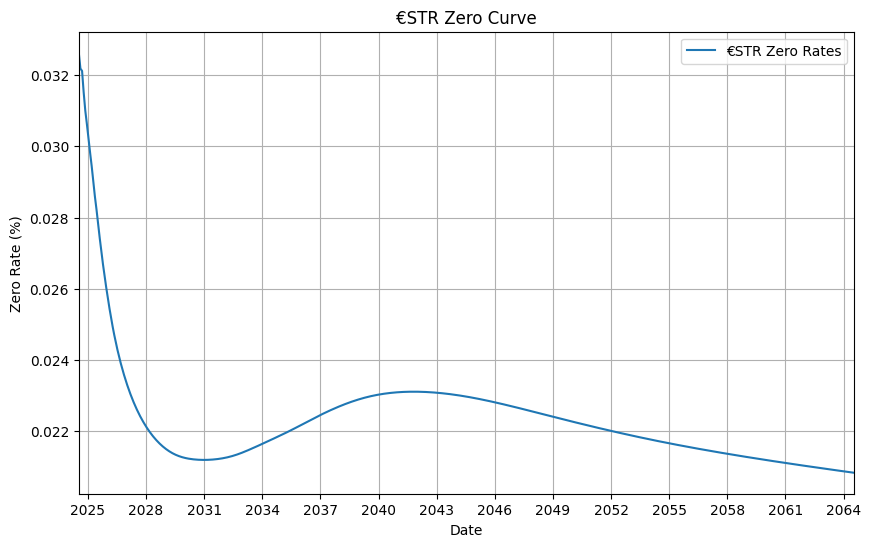

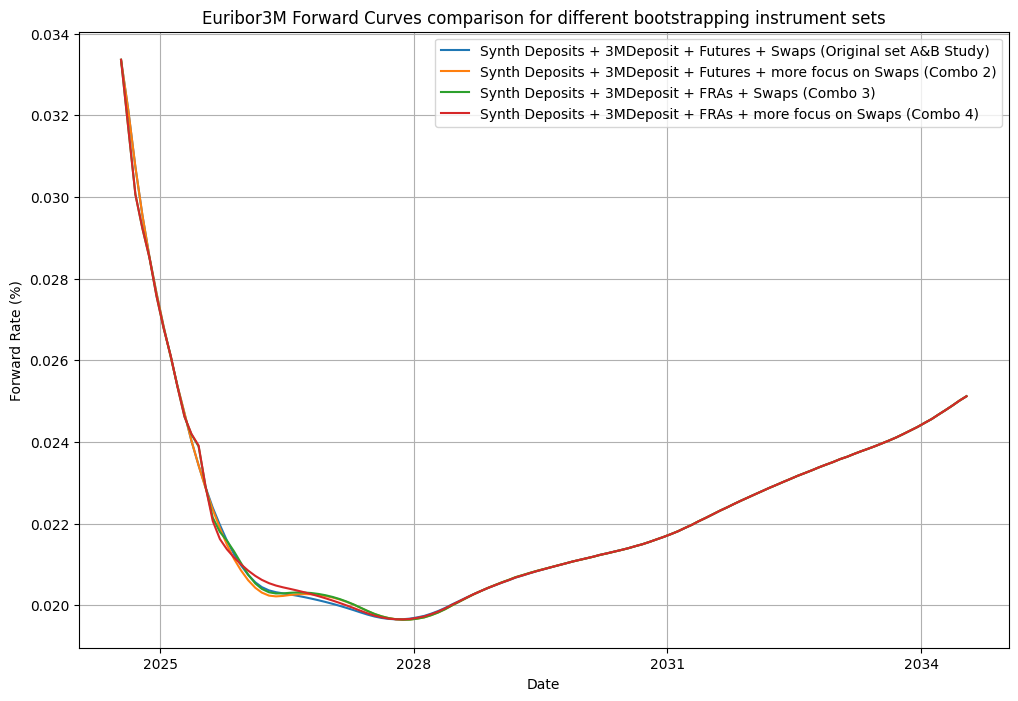

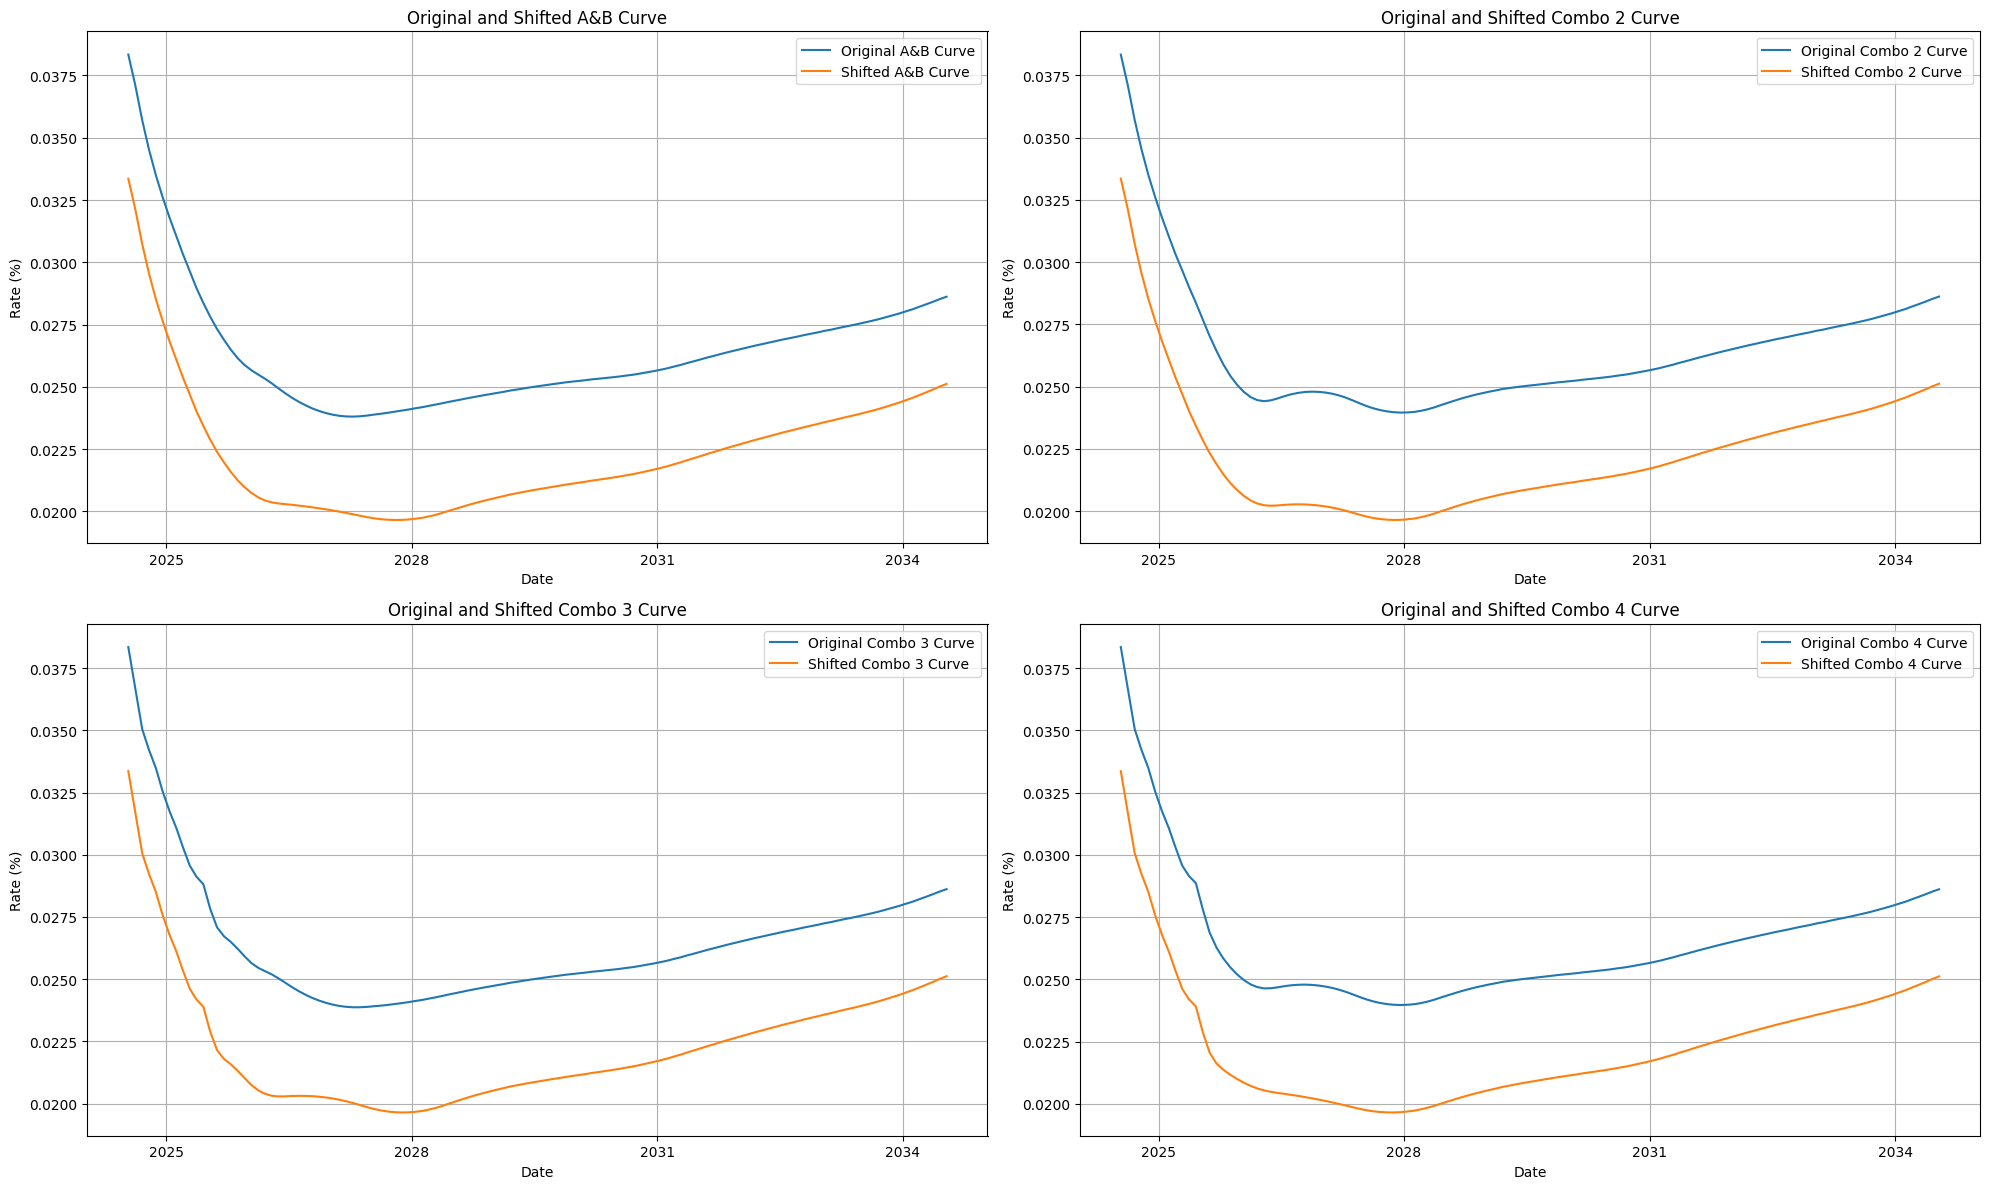

Statistical Analysis:
------------------------------------------------------------------------------------
Tracking Error (A&B curve): 41.717772550168775 basis points
Tracking Error Volatility (A&B curve): 4.4659705733594794 basis points
------------------------------------------------------------------------------------
Tracking Error (combo2 curve): 41.688167553750645 basis points
Tracking Error Volatility (combo2 curve): 4.074153594278411 basis points
------------------------------------------------------------------------------------
Tracking Error (combo3 curve): 41.72600111494541 basis points
Tracking Error Volatility (combo3 curve): 4.540957386196367 basis points
------------------------------------------------------------------------------------
Tracking Error (combo4 curve): 41.69355416076241 basis points
Tracking Error Volatility (combo4 curve): 4.125820949543677 basis points
------------------------------------------------------------------------------------


In [25]:
# Define Shifts and Pivot Dates
shift_start = -0.5  
shift_end = -0.1    

# Function to interpolate shifts smoothly between pivot dates
def smooth_interpolation(maturity_date, shift_start, shift_end, settle_date, last_date):
    total_days = (last_date - settle_date)
    days_to_maturity = (maturity_date - settle_date)
    shift = shift_start + (shift_end - shift_start) * (days_to_maturity / total_days)
    return shift

# Function to Apply Shocks to Data
def apply_shock(data, shift_start, shift_end, settle_date, last_date, is_futures=False):
    shifted_data = data.copy()
    for index, row in shifted_data.iterrows():
        maturity_date = row['Maturity_Date']
        shift = smooth_interpolation(maturity_date, shift_start, shift_end, settle_date, last_date)

        if is_futures:
            shifted_data.at[index, 'Mid_Rate'] -= shift
        else:
            shifted_data.at[index, 'Mid_Rate'] += shift
    return shifted_data


# Add Maturity Dates to Data
ois_data['Maturity_Date'] = ois_data['Period'].apply(lambda x: ql.TARGET().advance(settle_date, x))
deposit_data['Maturity_Date'] = deposit_data['Period'].apply(lambda x: ql.TARGET().advance(settle_date, x))
fra_data3M['Maturity_Date'] = fra_data3M['Start_Period'].apply(lambda x: ql.TARGET().advance(settle_date, x))
forwards_ois_ecb_data['Maturity_Date'] = forwards_ois_ecb_data['Start_Period']
swap_data3M['Maturity_Date'] = swap_data3M['Period'].apply(lambda x: ql.TARGET().advance(settle_date, x))
futures_data3M['Maturity_Date'] = futures_data3M['Start_Date']

# Get Last Maturity Date
all_maturities = pd.concat([
    ois_data['Maturity_Date'],
    deposit_data['Maturity_Date'],
    fra_data3M['Maturity_Date'],
    forwards_ois_ecb_data['Maturity_Date'],
    swap_data3M['Maturity_Date'],
    futures_data3M['Maturity_Date']
])
last_date = all_maturities.max()

# Apply Shocks to Data
s_ois_data = apply_shock(ois_data, shift_start, shift_end, settle_date, last_date)
s_deposit_data = apply_shock(deposit_data, shift_start, shift_end, settle_date, last_date)
s_fra_data3M = apply_shock(fra_data3M, shift_start, shift_end, settle_date, last_date)
s_forwards_ois_ecb_data = apply_shock(forwards_ois_ecb_data, shift_start, shift_end, settle_date, last_date)
s_swap_data3M = apply_shock(swap_data3M, shift_start, shift_end, settle_date, last_date)
s_futures_data3M = apply_shock(futures_data3M, shift_start, shift_end, settle_date, last_date, is_futures=True)

# Debugging: Print Shifted Data
DEBUG_SHIFTED_DATA = False
if DEBUG_SHIFTED_DATA:
    print(f"shifted ois: {s_ois_data[['Mid_Rate', 'Maturity_Date']]}")
    print(f"ois: {ois_data[['Mid_Rate', 'Maturity_Date']]}")
    print(f"shifted deposit: {s_deposit_data[['Mid_Rate', 'Maturity_Date']]}")
    print(f"deposit: {deposit_data[['Mid_Rate', 'Maturity_Date']]}")
    print(f"shifted fra: {s_fra_data3M[['Mid_Rate', 'Maturity_Date']]}")
    print(f"fra: {fra_data3M[['Mid_Rate', 'Maturity_Date']]}")
    print(f"shifted forwards: {s_forwards_ois_ecb_data[['Mid_Rate', 'Maturity_Date']]}")
    print(f"forwards: {forwards_ois_ecb_data[['Mid_Rate', 'Maturity_Date']]}")
    print(f"shifted swap: {s_swap_data3M[['Mid_Rate', 'Maturity_Date']]}")
    print(f"swap: {swap_data3M[['Mid_Rate', 'Maturity_Date']]}")
    print(f"shifted futures: {s_futures_data3M[['Mid_Rate', 'Maturity_Date']]}")
    print(f"futures: {futures_data3M[['Mid_Rate', 'Maturity_Date']]}")

# Rebuild Curves Using Shifted Data
s_estr_curve, s_estr_helpers, s_zero_rates =    estr_curve_builder(
                                                ois_data=s_ois_data,
                                                deposit_data=s_deposit_data,
                                                forwards_ois_ecb_data= s_forwards_ois_ecb_data,
                                                graph=True)

s_Euribor3M_curve_no_synth_depo, s_euribor3m_f_curve_no_synth_depo, s_deposit_helper_3m, s_future_helpers, s_swap_helpers_dual, spot_date, Euribor3M =  euribor_curve_builder_no_synth_depo(
                                                                                                                                                        estr_curve=s_estr_curve,
                                                                                                                                                        deposit_data=s_deposit_data,
                                                                                                                                                        futures_data3M=s_futures_data3M,
                                                                                                                                                        swap_data3M=s_swap_data3M,
                                                                                                                                                        graph=False)

s_synth_deposit_helper_ON_to_2M = synthetic_deposit_builder(Euribor3M_curve_no_synth_depo=s_Euribor3M_curve_no_synth_depo,
                                                            estr_curve=s_estr_curve,
                                                            print_alpha=False)

s_Euribor3M_curve_with_synth_depo, s_euribor3m_f_curve_dual =   euribor_curve_builder_with_synth_depo(
                                                                synth_deposit_helper_ON_to_2M=s_synth_deposit_helper_ON_to_2M,
                                                                deposit_helper_3m=s_deposit_helper_3m,
                                                                future_helpers=s_future_helpers,
                                                                swap_helpers_dual=s_swap_helpers_dual,
                                                                graph=False)

s_euribor3m_f_curve_dual, s_euribor3m_f_curve_combo2, s_euribor3m_f_curve_combo3, s_euribor3m_f_curve_combo4, dates =   different_i_b_sets_curves_builder(
                                                                                                                        synth_deposit_helper_ON_to_2M=s_synth_deposit_helper_ON_to_2M,
                                                                                                                        deposit_helper_3m=s_deposit_helper_3m,
                                                                                                                        swap_helpers_dual=s_swap_helpers_dual,
                                                                                                                        estr_curve=s_estr_curve,
                                                                                                                        Euribor3M_curve_with_synth_depo=s_Euribor3M_curve_with_synth_depo,
                                                                                                                        futures_data3M=s_futures_data3M,
                                                                                                                        swap_data3M=s_swap_data3M,
                                                                                                                        fra_data3M=s_fra_data3M,
                                                                                                                        graph=False)



# Create a figure and a grid of subplots
dates_dt = [_to_datetime(date) for date in dates]

fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# First subplot: Original A&B Curve
axs[0, 0].plot(dates_dt, euribor3m_f_curve, label='Original A&B Curve')
axs[0, 0].plot(dates_dt, s_euribor3m_f_curve_dual, label='Shifted A&B Curve')
axs[0, 0].xaxis.set_major_locator(mdates.YearLocator(3))
axs[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Rate (%)')
axs[0, 0].set_title('Original and Shifted A&B Curve')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Second subplot: Combo 2 Curve
axs[0, 1].plot(dates_dt, euribor3m_f_curve_combo2, label='Original Combo 2 Curve')
axs[0, 1].plot(dates_dt, s_euribor3m_f_curve_combo2, label='Shifted Combo 2 Curve')
axs[0, 1].xaxis.set_major_locator(mdates.YearLocator(3))
axs[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Rate (%)')
axs[0, 1].set_title('Original and Shifted Combo 2 Curve')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Third subplot: Combo 3 Curve
axs[1, 0].plot(dates_dt, euribor3m_f_curve_combo3, label='Original Combo 3 Curve')
axs[1, 0].plot(dates_dt, s_euribor3m_f_curve_combo3, label='Shifted Combo 3 Curve')
axs[1, 0].xaxis.set_major_locator(mdates.YearLocator(3))
axs[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Rate (%)')
axs[1, 0].set_title('Original and Shifted Combo 3 Curve')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Fourth subplot: Combo 4 Curve
axs[1, 1].plot(dates_dt, euribor3m_f_curve_combo4, label='Original Combo 4 Curve')
axs[1, 1].plot(dates_dt, s_euribor3m_f_curve_combo4, label='Shifted Combo 4 Curve')
axs[1, 1].xaxis.set_major_locator(mdates.YearLocator(3))
axs[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Rate (%)')
axs[1, 1].set_title('Original and Shifted Combo 4 Curve')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

#=========================Statistical Analysis============================================

# Calculate Differences Between Curves
differences_A_and_B_array = np.array(euribor3m_f_curve) - np.array(s_euribor3m_f_curve_dual)
differences_combo2_array = np.array(euribor3m_f_curve_combo2) - np.array(s_euribor3m_f_curve_combo2)
differences_combo3_array = np.array(euribor3m_f_curve_combo3) - np.array(s_euribor3m_f_curve_combo3)
differences_combo4_array = np.array(euribor3m_f_curve_combo4) - np.array(s_euribor3m_f_curve_combo4)


# Define a date 10 years from the settle_date
data_range = settle_date + ql.Period(10, ql.Years)

# Filter the dates and differences arrays to only include dates within the first 10 years
filtered_dates = [d for d in dates if d <= data_range]
filtered_indices = [i for i, d in enumerate(dates) if d <= data_range]

# Filter the differences arrays
filtered_differences_A_and_B = differences_A_and_B_array[filtered_indices]
filtered_differences_combo2 = differences_combo2_array[filtered_indices]
filtered_differences_combo3 = differences_combo3_array[filtered_indices]
filtered_differences_combo4 = differences_combo4_array[filtered_indices]


# Calculate Tracking Error and Tracking Error Volatility (in basis points) for the first 10 years
tracking_error_A_and_B = np.sqrt(np.mean(filtered_differences_A_and_B**2)) * 10000
tracking_error_vol_dual = np.std(filtered_differences_A_and_B) * 10000

tracking_error_combo2 = np.sqrt(np.mean(filtered_differences_combo2**2)) * 10000
tracking_error_vol_combo2 = np.std(filtered_differences_combo2) * 10000

tracking_error_combo3 = np.sqrt(np.mean(filtered_differences_combo3**2)) * 10000
tracking_error_vol_combo3 = np.std(filtered_differences_combo3) * 10000

tracking_error_combo4 = np.sqrt(np.mean(filtered_differences_combo4**2)) * 10000
tracking_error_vol_combo4 = np.std(filtered_differences_combo4) * 10000


# Print Statistical Results
print("Statistical Analysis:")
print("------------------------------------------------------------------------------------")
print(f"Tracking Error (A&B curve): {tracking_error_A_and_B} basis points")
print(f"Tracking Error Volatility (A&B curve): {tracking_error_vol_dual} basis points")
print("------------------------------------------------------------------------------------")
print(f"Tracking Error (combo2 curve): {tracking_error_combo2} basis points")
print(f"Tracking Error Volatility (combo2 curve): {tracking_error_vol_combo2} basis points")
print("------------------------------------------------------------------------------------")
print(f"Tracking Error (combo3 curve): {tracking_error_combo3} basis points")
print(f"Tracking Error Volatility (combo3 curve): {tracking_error_vol_combo3} basis points")
print("------------------------------------------------------------------------------------")
print(f"Tracking Error (combo4 curve): {tracking_error_combo4} basis points")
print(f"Tracking Error Volatility (combo4 curve): {tracking_error_vol_combo4} basis points")
print("------------------------------------------------------------------------------------")


The statistical analysis shows that all curves exhibit good stability, with Tracking Errors around 41.7 basis points. In terms of Tracking Error Volatility, Combo 2 is the most stable at 4.07 basis points, followed by Combo 4 at 4.13 basis points, the A&B curve at 4.47 basis points, and Combo 3 at 4.54 basis points. These results suggest that while all curves are relatively stable, Combo 2 and Combo 4 are slightly more robust against market shocks.